# **SIN 393 – Introduction to Computer Vision (2024)**

# Lecture 01 - Part 2 - Image classification

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importing the required libraries
---

In [1]:
import os

import numpy as np
from skimage import util, transform, filters, color, measure, morphology
from sklearn import model_selection, neighbors, metrics, preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### %matplotlib notebook
### %matplotlib widget

## The dataset: Flavia leaf dataset
---
* A set of leaf images
* Flavia leaf dataset:
    * http://flavia.sourceforge.net/ 
    * 1.907 images
    * 33 classes

### Reduced versions of the Flavia set

* Full dataset (all images of 33 classes)
    * ```data/flavia```
* All images of 3 classes
    * ```data/flavia_toy```
* Only 6 images of 3 classes
    * ```data/flavia_toy2```

In [2]:
# 33 classes - Full dataset
### ds_path = 'data/flavia'

# 3 classes - Full dataset
ds_path = 'data/flavia_toy'

# 3 classes - 6 images per class
### ds_path = 'data/flavia_toy2'

In [3]:
print(ds_path)

data/flavia_toy


## Loading the images from the dataset

In [4]:
# List of folders in the 'ds_path' directory (class names)
classes_list = os.listdir(ds_path)

# List of images in the dataset
image_list = []
# List of image labels
label_list = []

# List of image filenames
filename_list_ = []

# Iterate through the dataset classes
for classe in classes_list:
    
    # List all images in the current class folder
    filename_list = os.listdir(os.path.join(ds_path, classe))
    
    # Iterate through the files in the current folder
    for filename in filename_list:
        # Load the image
        img_temp = plt.imread(os.path.join(ds_path, classe, filename))
        
        # Resize the image to 1/4 of the original size
        img_temp = transform.resize(img_temp, (img_temp.shape[0]//4, img_temp.shape[1]//4), anti_aliasing=True)
        
        # Add the image to the image list
        image_list.append(img_temp)
        
        # Add the image label to the label list
        label_list.append(classe)
        
        # Add the image filename to a list (for visualization purposes)
        filename_list_.append(filename)

In [5]:
# Convert to numpy array
label_list = np.array(label_list)
# List of image labels
print(label_list)

['acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'acer_palmatum' 'acer_palmatum' 'acer_palmatum'
 'aesculus_chinensis' 'aesculus_chinensis' 'aesculus_chinensis'
 'aesculus_chinensis' 'aes

### Visualizing Dataset Images

* Displaying the first N images from each class.
* This step is important for gaining an initial understanding of the dataset.

In [6]:
# Select only the first N images from each class
image_list_temp = []
filename_list_temp = []

# Iterate through the number of classes
for i, class_name in enumerate(classes_list):
    print(i, class_name)
    # The first 6 occurrences where label_list matches class_name
    # Image
    image_list_temp += [image_list[j] for j in np.where(label_list == class_name)[0][:6]]
    # Filename
    filename_list_temp += [filename_list_[j] for j in np.where(label_list == class_name)[0][:6]]  

0 acer_palmatum
1 aesculus_chinensis
2 cersis_chinensis


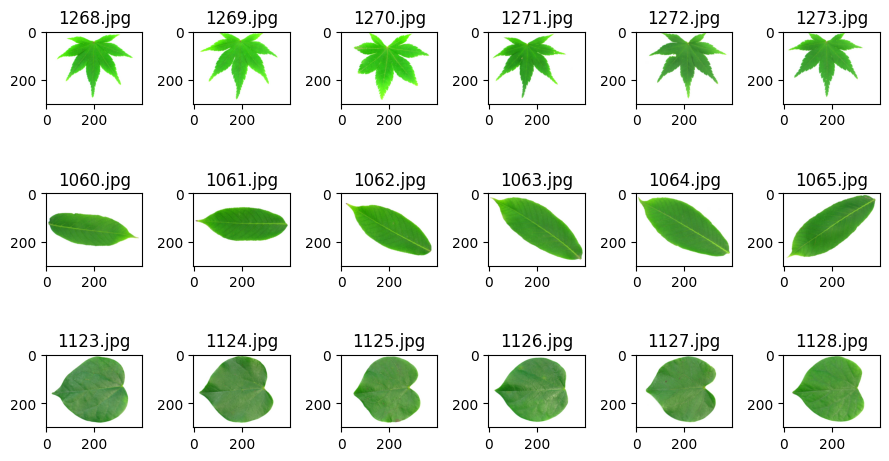

In [7]:
fig, ax  = plt.subplots(3, 6, figsize=(9, 5))

for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, vmin=0, vmax=255)
    ax[i//6, i%6].set_title(str(filename))
    ### ax[i//6, i%6].axis('off')

fig.tight_layout()
plt.show()

## Extracting Features from Images
---

* We will extract shape features from the objects in the images, including:
    * Area, major axis, minor axis, solidity, and eccentricity.
* To achieve this, the leaves in the images need to be segmented first. The process involves:
    1. Converting the image data type to float;
    1. Transforming the image from RGB to grayscale;
    1. Segmenting the image using the Otsu thresholding method;
    1. Removing segmentation artifacts smaller than 10,000 pixels.

In [8]:
# Feature names
features = ['area', 'major_axis', 'minor_axis', 'solidity', 'eccentricity']

In [9]:
# 2D array with image features
# Each row stores information about an image, and each column represents a feature.
# [ [area, major_axis, minor_axis, solidity, eccentricity] ]
feature_mat = []

# List of segmented (binary) images
seg_list = []

# List of image labels
list_label = []

for i, (image, label) in enumerate(zip(image_list, label_list)):
    # DEBUG
    print(f'Image {i} - Class {label}')
    
    # Add the image label to the label list
    list_label.append(label)
    
    # Image Segmentation
    # --------------------------------------------------
    # Convert the image to float
    img_float = util.img_as_float(image)
    # DEBUG
    # print(img_float.shape, img_float.min(), img_float.max())
    
    # Convert the image to grayscale
    img_float = color.rgb2gray(img_float)
    
    # Perform segmentation using Otsu thresholding
    img_seg = img_float < filters.threshold_otsu(img_float)
    # print(img_seg.shape, img_seg.min(), img_seg.max())
    
    # Remove objects smaller than N pixels
    img_seg = morphology.remove_small_objects(img_seg, 10000)
    
    # Add the segmented image to the list
    seg_list.append(img_seg)
    
    # Compute labeled image
    im_lbl = measure.label(img_seg)
    
    # Compute a list of properties (features) for the objects in the image
    props = measure.regionprops(im_lbl)
    
    # Check for segmentation issues
    if len(props) != 1:
        print(f'Segmentation ERROR: {len(props)} objects detected')
        continue

    # Iterate through the computed properties
    for prop in props:
        # Feature 0: Area
        area = prop.area
        # Feature 1: Major axis length
        major_axis = prop.major_axis_length
        # Feature 2: Minor axis length
        minor_axis = prop.minor_axis_length
        # Feature 3: Solidity
        solidity = prop.solidity
        # Feature 4: Eccentricity
        eccentricity = prop.eccentricity
        # Assemble the feature vector for this object
        feature_list = [area, major_axis, minor_axis, solidity, eccentricity]
    
    # Add the features of this image to the feature matrix
    feature_mat.append(feature_list)

Image 0 - Class acer_palmatum
Image 1 - Class acer_palmatum
Image 2 - Class acer_palmatum
Image 3 - Class acer_palmatum
Image 4 - Class acer_palmatum
Image 5 - Class acer_palmatum
Image 6 - Class acer_palmatum
Image 7 - Class acer_palmatum
Image 8 - Class acer_palmatum
Image 9 - Class acer_palmatum
Image 10 - Class acer_palmatum
Image 11 - Class acer_palmatum
Image 12 - Class acer_palmatum
Image 13 - Class acer_palmatum
Image 14 - Class acer_palmatum
Image 15 - Class acer_palmatum
Image 16 - Class acer_palmatum
Image 17 - Class acer_palmatum
Image 18 - Class acer_palmatum
Image 19 - Class acer_palmatum
Image 20 - Class acer_palmatum
Image 21 - Class acer_palmatum
Image 22 - Class acer_palmatum
Image 23 - Class acer_palmatum
Image 24 - Class acer_palmatum
Image 25 - Class acer_palmatum
Image 26 - Class acer_palmatum
Image 27 - Class acer_palmatum
Image 28 - Class acer_palmatum
Image 29 - Class acer_palmatum
Image 30 - Class acer_palmatum
Image 31 - Class acer_palmatum
Image 32 - Class a

In [10]:
print(type(feature_mat))

# Convert the feature list to a NumPy array
feature_mat = np.array(feature_mat)
print(type(feature_mat))

# Print the feature matrix
with np.printoptions(precision=4, suppress=True):
    print(feature_mat.shape)

<class 'list'>
<class 'numpy.ndarray'>
(191, 5)


In [11]:
# Some statistics about the feature set
with np.printoptions(precision=4, suppress=True):
    print(feature_mat.min(0))
    print(feature_mat.max(0))
    print(feature_mat.mean(0))
    print(feature_mat.std(0))

[17632.       186.1457   115.8967     0.4389     0.0952]
[62852.       414.4433   273.5043     0.9846     0.9333]
[42335.4555   290.3434   203.0027     0.8368     0.5644]
[11898.8393    63.574     44.8523     0.2023     0.2619]


### Plotting a subset of segmented images from each class

In [12]:
# Select only the first N images from each class
seg_list_temp = []
filename_list_temp = []

# Iterate through the number of classes
for i, class_name in enumerate(classes_list):
    # The first 6 occurrences where the label matches 'class_name'
    seg_list_temp += [seg_list[j] for j in np.where(label_list == class_name)[0][:6]]
    filename_list_temp += [filename_list_[j] for j in np.where(label_list == class_name)[0][:6]]

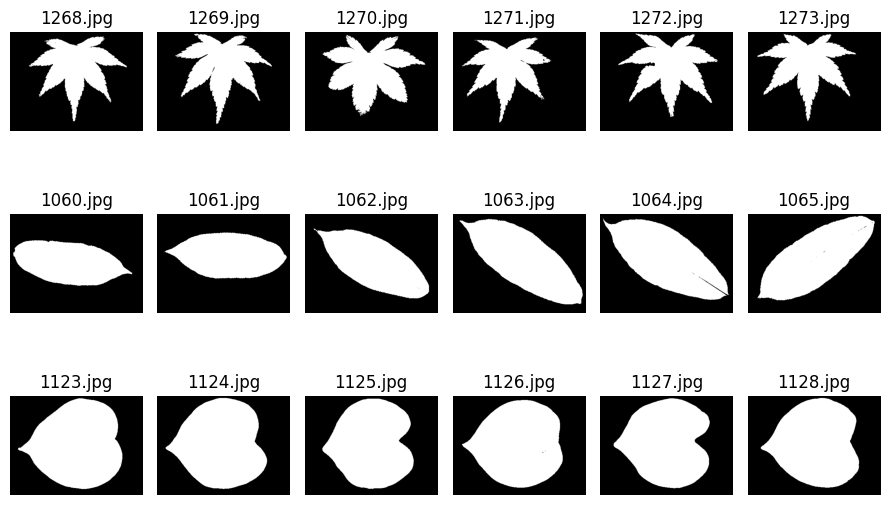

In [13]:
fig, ax  = plt.subplots(3, 6, figsize=(9, 6))

for i, (image, filename) in enumerate(zip(seg_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, cmap='gray')
    ax[i//6, i%6].set_title(str(filename))
    ax[i//6, i%6].axis('off')
    
fig.tight_layout()
plt.show()

### Plotting the computed features

In [14]:
df = pd.DataFrame(feature_mat, columns=features)
df['class'] = label_list

### print(df)
display(df)

,area,major_axis,minor_axis,solidity,eccentricity,class
0,29335.0,232.175652,199.506366,0.555829,0.511488,acer_palmatum
1,30990.0,233.525495,212.554472,0.545685,0.414173,acer_palmatum
2,35396.0,258.027906,208.486083,0.653135,0.589185,acer_palmatum
3,27018.0,223.482678,195.044617,0.524581,0.488167,acer_palmatum
4,30928.0,244.160662,203.943848,0.525700,0.549817,acer_palmatum
...,...,...,...,...,...,...
186,52762.0,275.851396,249.959329,0.959693,0.422983,cersis_chinensis
187,55364.0,278.685695,255.949680,0.969105,0.395614,cersis_chinensis
188,50414.0,278.638768,236.241707,0.955716,0.530249,cersis_chinensis
189,51698.0,271.726867,246.742366,0.964983,0.418856,cersis_chinensis


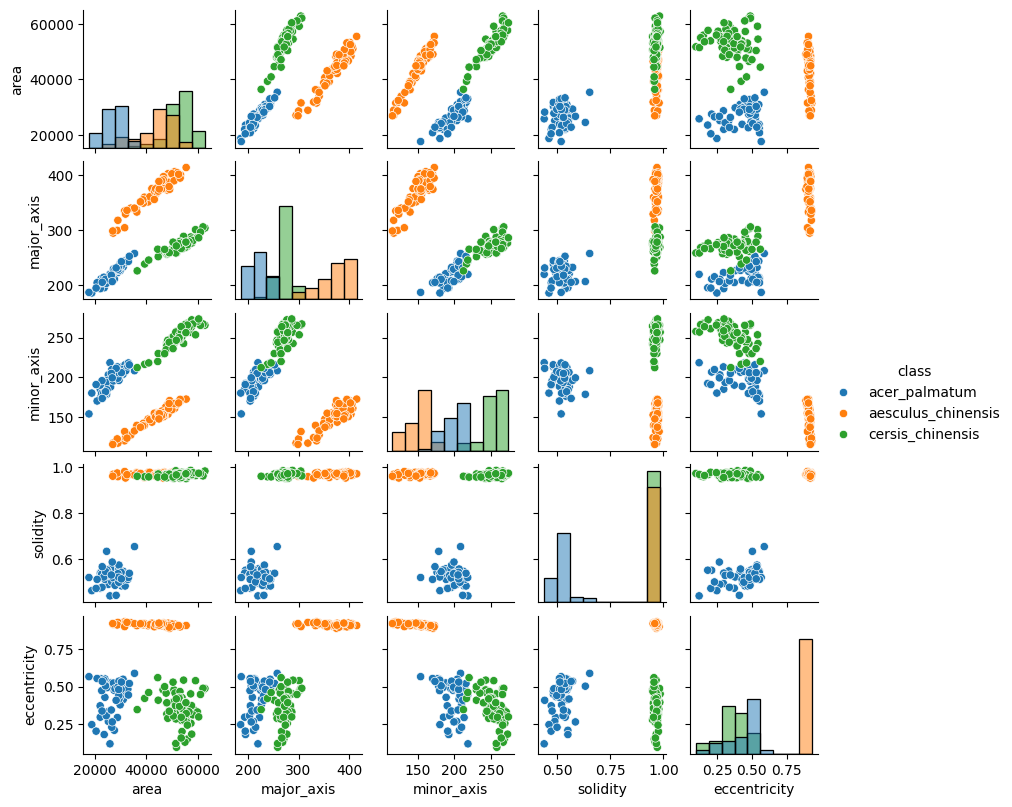

In [15]:
g = sns.PairGrid(df, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Cross-Validation - Hold-Out  
---  

* The dataset is divided into subsets for training, validation, and testing.  
    * In this example, for simplicity, we will only split it into training and testing. 

In [16]:
# Selecting only two features: Area and Major Axis
feature_mat_ok = feature_mat[:,0:2]

In [17]:
# Split the dataset into 'feature_mat_ok' based on 'label_list'.
# 30% of the images are allocated to the test set.
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_mat_ok, 
                                                                    label_list, 
                                                                    test_size=0.3, 
                                                                    random_state=42)

### Normalizing Features  

* Normalization **should not** be performed on the entire dataset.  
    * Normalization must be done **after** splitting the dataset for cross-validation.  
    * The test set must not be accessed, either directly or indirectly, during training or hyperparameter tuning.  
    * Both the training and test sets should be normalized using only the mean and standard deviation of the training set.  

In [18]:
# Mean of the features in the training set
X_train_mean = X_train.mean(0)
# Standard deviation of the features in the training set
X_train_std = X_train.std(0)

with np.printoptions(precision=4, suppress=True):
    print(X_train.mean(0))
    print(X_train.std(0))

[41870.8496   288.7018]
[11396.789    61.97 ]


In [19]:
# Normal feature transform (Standard Scaler)
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

with np.printoptions(precision=4, suppress=True):
    print(X_train_norm.mean(0))
    print(X_test_norm.mean(0))

[-0. -0.]
[0.1342 0.0872]


## Classifying using K-Nearest Neighbors  
---  

In [20]:
# Build a K-NN classifier
# K = 3
clf = neighbors.KNeighborsClassifier(n_neighbors=3)

# Train the classifier
clf.fit(X_train_norm, y_train)

# Test the classifier
pred = clf.predict(X_test_norm)

## Evaluating the model
---

In [21]:
# Hits
acertos = y_test == pred

print('\n Prediction:')
print(pred)
print('\nTrue:')
print(y_test)
print('\nHit/Error:')
print(acertos.astype(int))


 Prediction:
['cersis_chinensis' 'aesculus_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'cersis_chinensis' 'cersis_chinensis' 'cersis_chinensis'
 'cersis_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'aesculus_chinensis' 'aesculus_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'aesculus_chinensis'
 'acer_palmatum' 'acer_palmatum' 'aesculus_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'aesculus_chinensis'
 'cersis_chinensis' 'cersis_chinensis' 'acer_palmatum'
 'aesculus_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'acer_palmatum'
 'cersis_chinensis' 'acer_palmatum' 'cersis_chinensis' 'cersis_chinensis'
 'acer_palmatum' 'cersis_chin

### Matriz de confusão e o relatório de treinamento

In [22]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_test, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_test, pred))


Matriz de confusão:
[[17  0  0]
 [ 0 19  0]
 [ 0  0 22]]

Relatório de classificação:
                    precision    recall  f1-score   support

     acer_palmatum       1.00      1.00      1.00        17
aesculus_chinensis       1.00      1.00      1.00        19
  cersis_chinensis       1.00      1.00      1.00        22

          accuracy                           1.00        58
         macro avg       1.00      1.00      1.00        58
      weighted avg       1.00      1.00      1.00        58



## Optimizing Hyperparameters with the Validation Set  
---  
* Hyperparameter optimization should not be performed using the test set.  
* Instead, a portion of the training set is reserved for validation.  
* To do this using Scikit-learn:  
    * First, split the total dataset into test and training sets.  
    * Then, split the training set into validation and final training sets.  

* *Example:* 20% for testing, 20% for validation, and 60% for training.  

```
+-- Dataset - 100%
     +-- Test set - 20%
     +-- Training set 1 - 80%
         +-- Validation set - 20% of the dataset = 25% of training set 1 (0.2 / 0.8 = 0.25)
         +-- Training set 2 - 60% of the dataset = 75% of training set 1 (0.8 * 0.75 = 0.6)
```

* However, the previous example was too simple to solve, and we achieved 100% accuracy on the first attempt.
* Let's choose different features to make the task a bit more challenging for our classifier.

In [23]:
# We selected only two features: Area and solidity
feature_map_ok = feature_mat[:,[0,3]]

* Let's improve the dataset splitting as well. We will adopt a stratified split.  
    * Stratified splitting preserves the proportion of samples from each class in the training, validation, and test sets.    

In [24]:
# Split 20% of the full dataset for TESTING and 80% for Training 1.
X_train_1, X_test, y_train_1, y_test = model_selection.train_test_split(feature_map_ok, 
                                                                        label_list, 
                                                                        test_size=0.2, 
                                                                        stratify=label_list, # Stratified spliting
                                                                        random_state=42)

In [25]:
# Split 25% of Training Set 1 for validation.
#   -> This is equivalent to 20% of the full dataset. 0.2 / 0.8 = 0.25
X_train_2, X_val, y_train_2, y_val = model_selection.train_test_split(X_train_1, 
                                                                      y_train_1, 
                                                                      test_size=0.25, 
                                                                      stratify=y_train_1, # Stratified spliting
                                                                      random_state=42)

### Normalizing Features  
* The mean and standard deviation of the data are estimated from the training set. 

In [26]:
# Mean of the features in the training set
X_train_2_mean = X_train_2.mean(0)

# Standard deviation of the features in the training set
X_train_2_std = X_train_2.std(0)

with np.printoptions(precision=4, suppress=True):
    print(X_train_2.mean(0))
    print(X_train_2.std(0))

[42514.6842     0.834 ]
[12227.2288     0.2037]


* We will normalize the training, validation, and test sets using the mean and standard deviation calculated from the training set.  
* Unlike the previous example (simple hold-out with only training and testing), where features were normalized manually, here we will use the function available in Scikit-learn.  

In [27]:
# Normal feature transform - Standard Scaler (Manual)
# ----
# X_train_2_norm = (X_train_2 - X_train_2_mean) / X_train_2_std
# X_val_norm = (X_val - X_train_2_mean) / X_train_2_std
# X_test_norm = (X_test - X_train_2_mean) / X_train_2_std

# Normal feature transform - Standard Scaler (Sklearn)
# ----
scaler = preprocessing.StandardScaler().fit(X_train_2)
with np.printoptions(precision=4, suppress=True):
    print(f'Mean:  \t {np.array(scaler.mean_)}')
    print(f'Std. dev.: \t {np.array(scaler.scale_)}')

Mean:  	 [42514.6842     0.834 ]
Std. dev.: 	 [12227.2288     0.2037]


In [28]:
X_train_2_norm = scaler.transform(X_train_2)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

with np.printoptions(precision=4, suppress=True):
    print(f'train: \t {X_train_norm.mean():.4f} ± {X_train_norm.std():.4f}')
    print(f'Val.: \t {X_val_norm.mean():.4f} ± {X_val_norm.std():.4f}')
    print(f'Test:   \t {X_test_norm.mean():.4f} ± {X_test_norm.std():.4f}')

train: 	 -0.0000 ± 1.0000
Val.: 	 0.0010 ± 0.9209
Test:   	 -0.0036 ± 0.9930


### Optimizing the value of *k*  
* We will determine the optimal value of *k* for K-means in terms of accuracy.  
* The following values of *k* will be tested: 1, 3, 5, 7, and 9. 

In [29]:
k_list = [1, 3, 5, 7, 9]

In [30]:
# List of training accuracies
acc_train_list = []
# List of validation accuracies
acc_val_list = []

for k_ in k_list:
    # Build a K-NN classifier. K = k_
    clf = neighbors.KNeighborsClassifier(n_neighbors=k_)

    # Training the classifier
    clf.fit(X_train_2_norm, y_train_2)

    # Testing the classifier (using the validation set)
    pred = clf.predict(X_val_norm)
    acc_val = metrics.accuracy_score(y_val, pred)
    
    acc_val_list.append(acc_val)
    
    # Testing the classifier using the training set.
    # **** Just for comparison with the validation results and to check for overfitting ****
    pred_train = clf.predict(X_train_2_norm)
    acc_train = metrics.accuracy_score(y_train_2, pred_train)
    
    acc_train_list.append(acc_train)  

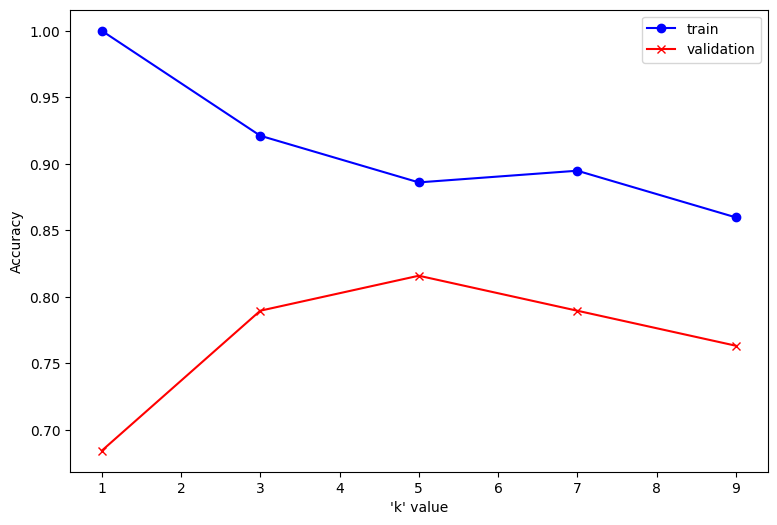

In [31]:
plt.figure(figsize=(9, 6))

plt.plot(k_list, acc_train_list, '-o', color='blue', label='train')
plt.plot(k_list, acc_val_list, '-x', color='red', label='validation')
plt.xlabel("'k' value")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.show()

In [32]:
print('k \t Train acc. \t Val acc.')
print('----------------------------')
for k_, acc_t, acc_v in zip(k_list, acc_train_list, acc_val_list):
    print(f'{k_} \t {acc_t:.4f} \t {acc_v:.4f}')

k_best = k_list[np.argmax(acc_val_list)]
print(f'\nBest \'k\': {k_best} ({np.max(acc_val_list):.4f} acc.)')

k 	 Train acc. 	 Val acc.
----------------------------
1 	 1.0000 	 0.6842
3 	 0.9211 	 0.7895
5 	 0.8860 	 0.8158
7 	 0.8947 	 0.7895
9 	 0.8596 	 0.7632

Best 'k': 5 (0.8158 acc.)


### Testing the best model with the test set  

In [33]:
# Build a K-NN classifier. K = k_best
clf = neighbors.KNeighborsClassifier(n_neighbors=k_best)

# Training the classifier
clf.fit(X_train_2_norm, y_train_2)

# Testing the classifier (using the TEST set)
pred = clf.predict(X_test_norm)
acc_val = metrics.accuracy_score(y_test, pred)

* Confusion matrix and classification report

In [34]:
print('\nConfusion matrix:')
print(metrics.confusion_matrix(y_test, pred))

print('\nClassification report:')
print(metrics.classification_report(y_test, pred))


Confusion matrix:
[[11  0  0]
 [ 0 11  2]
 [ 0  5 10]]

Classification report:
                    precision    recall  f1-score   support

     acer_palmatum       1.00      1.00      1.00        11
aesculus_chinensis       0.69      0.85      0.76        13
  cersis_chinensis       0.83      0.67      0.74        15

          accuracy                           0.82        39
         macro avg       0.84      0.84      0.83        39
      weighted avg       0.83      0.82      0.82        39



## Bibliography
---
* GONZALEZ, R.C.; WOODS, R.E. **Digital Image Processing.** 3rd ed. Pearson, 2007.
* COSTA, L. DA F.; CESAR-JR., R. M. **Shape analysis and classification: theory and practice.** CRC Press, 2000. Chapter 8.
* Scikit-image documentation.
    * https://scikit-image.org/docs/stable/
* scikit-learn - User Guide.
    * https://scikit-learn.org/stable/user_guide.html